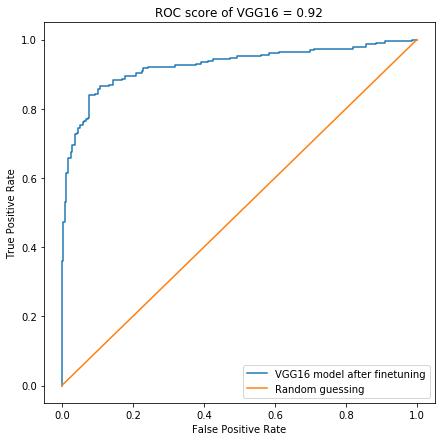

In [0]:
# Plot ROC curve
plt.rcParams["figure.figsize"] = (7,7)
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, thresholds = roc_curve(valid_label_list,predictions)
auc_score = roc_auc_score(valid_label_list,predictions)

plt.plot(fpr,tpr,label='Inception model after finetuning')
plt.plot(fpr,fpr,label='Random guessing')
plt.title('ROC score of Inception = %2.2f'%auc_score)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

plt.show()

In [0]:
# Get the classification report
from sklearn.metrics import classification_report

report = classification_report(predictions_binary,valid_label_list)
print(report)

              precision    recall  f1-score   support

           0       0.92      0.83      0.88       260
           1       0.81      0.91      0.86       205

   micro avg       0.87      0.87      0.87       465
   macro avg       0.87      0.87      0.87       465
weighted avg       0.87      0.87      0.87       465



# MURA project deep learning

### Updates - 04/23/2019
1. Selected on ELBOW for training our models.
2. Models(pre-built) are now training w/o errors.
3. Need to fix issue of stagnant train acc,loss and volatile valid acc,loss by shuffling train and valid lists.

### Updates - 04/20/2019
1. Reshaping the images to be of size 512x512 which is the size used in most of the MURA implementaions on github.
2. Reshaping is done by black padding the images so that the original image stays in the center.

Dataset and competition page - https://stanfordmlgroup.github.io/competitions/mura/

In [0]:
# Import necessary libraries

# Numerical computation
import numpy as np

# Data manipulation
import pandas as pd

# Deep Learning libraries
import tensorflow as tf
from tensorflow.python import keras

# Data Viz
import matplotlib.pyplot as plt
%matplotlib inline

# Operating system lib
import os

In [2]:
# Download the MURA dataset
# Reference -
from urllib.request import urlretrieve
from zipfile import ZipFile

def download(url, file):
    if not os.path.isfile(file):
        print("Download file... " + file + " ...")
        urlretrieve(url,file)
        print("File downloaded")

download('https://cs.stanford.edu/group/mlgroup/MURA-v1.1.zip','MURA.zip')
print("All the files are downloaded")

Download file... MURA.zip ...
File downloaded
All the files are downloaded


In [0]:
# Unzip the file
!unzip MURA.zip

Archive:  MURA.zip
   creating: MURA-v1.1/
  inflating: MURA-v1.1/train_labeled_studies.csv  
  inflating: MURA-v1.1/valid_labeled_studies.csv  
  inflating: MURA-v1.1/train_image_paths.csv  
  inflating: MURA-v1.1/valid_image_paths.csv  
   creating: MURA-v1.1/valid/
   creating: MURA-v1.1/valid/XR_ELBOW/
   creating: MURA-v1.1/valid/XR_ELBOW/patient11817/
   creating: MURA-v1.1/valid/XR_ELBOW/patient11817/study1_positive/
 extracting: MURA-v1.1/valid/XR_ELBOW/patient11817/study1_positive/image1.png  
  inflating: MURA-v1.1/valid/XR_ELBOW/patient11817/study1_positive/image5.png  
  inflating: MURA-v1.1/valid/XR_ELBOW/patient11817/study1_positive/image2.png  
 extracting: MURA-v1.1/valid/XR_ELBOW/patient11817/study1_positive/image3.png  
 extracting: MURA-v1.1/valid/XR_ELBOW/patient11817/study1_positive/image4.png  
   creating: MURA-v1.1/valid/XR_ELBOW/patient11860/
   creating: MURA-v1.1/valid/XR_ELBOW/patient11860/study1_negative/
  inflating: MURA-v1.1/valid/XR_ELBOW/patient11860/s

In [3]:
# Change working directory and display the files and folders within the MURA-v1.1 directory
os.chdir('MURA-v1.1')
os.listdir()

['train_labeled_studies.csv',
 'valid_image_paths.csv',
 'valid',
 'valid_labeled_studies.csv',
 'train',
 'train_image_paths.csv']

In [4]:
# Load the csv file as a pandas df containing the training image paths
train_image_paths = pd.read_csv('train_image_paths.csv',header=None)
train_image_paths.columns = ['image_path']
train_image_paths.head(5)

# Load the csv file as a pandas df containing the validation image paths
valid_image_paths = pd.read_csv('valid_image_paths.csv',header=None)
valid_image_paths.columns = ['image_path']
valid_image_paths.head(5)

image_path
0  MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...
1  MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...
2  MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...
3  MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...
4  MURA-v1.1/valid/XR_WRIST/patient11186/study1_p...

In [3]:
# Load the csv file as a pandas df containing the training study labels
train_labelled_studies = pd.read_csv('train_labeled_studies.csv',header=None)
train_labelled_studies.columns = ['study_name','label']
train_labelled_studies.head(5)
print(train_labelled_studies.shape)


# Load the csv file as a pandas df containing the validation study labels
valid_labelled_studies = pd.read_csv('valid_labeled_studies.csv',header=None)
valid_labelled_studies.columns = ['study_name','label']
valid_labelled_studies.head(5)

FileNotFoundError: ignored

In [0]:
# Go back one directory to the parent
os.chdir('..')

In [0]:

def addImageLists(df):
  """
  Function which takes a studies dataframe (train or valid) and returns the dataframe after adding a new column containing lists of images in that study
  """
  # Our column containing a list of images for each study
  images = []

  for study_name in df['study_name']:
    image_list = [study_name+image_name for image_name in os.listdir(study_name)]
    images.append(image_list)
    
  # Add the column and return the dataframe
  df['images'] = images
  return df
  

In [0]:
# Create the new train_labelled_studies df for EDA
train_labelled_studies = addImageLists(train_labelled_studies)
# Create the new valid_labelled_studies df for EDA
valid_labelled_studies = addImageLists(valid_labelled_studies)

In [0]:
# Filter data relevant only to a particular body part
# MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/

BODY_PART = 'XR_ELBOW'

# Filter the train dataframe for a particular body part
train_labelled_studies = train_labelled_studies[train_labelled_studies['study_name'].str.contains(BODY_PART)]

# Filter the valid dataframe for a particular body part
valid_labelled_studies = valid_labelled_studies[valid_labelled_studies['study_name'].str.contains(BODY_PART)]

In [0]:
def createImageLists(df):
  """
  Function which takes a studies dataframe (train or valid) and returns the dataframe after adding a new column containing lists of images in that study
  """
  # Our column containing a list of images for each study
  images = []
  labels = []
  
  for index, row in df.iterrows():
    
    study_name = row['study_name']
    label = row['label']
    
    for image_name in os.listdir(study_name):
      images.append(study_name+image_name)
      labels.append(label)
    
  return images,labels

In [0]:
# Generate the train image and label lists
train_image_list, train_label_list = createImageLists(train_labelled_studies)

# Generate the validation image and label lists
valid_image_list, valid_label_list = createImageLists(valid_labelled_studies)

In [0]:
# Shuffle train and valid lists
import sklearn
from sklearn.utils import shuffle

train_image_list, train_label_list = shuffle(train_image_list, train_label_list)

valid_image_list, valid_label_list = shuffle(valid_image_list, valid_label_list)

In [0]:
# Start an interactive tf session
sess = tf.InteractiveSession()

### Data pipeline to do list
1. Create a dataframe having the study directory, list of image paths and labels as a dataframe - DONE
2. Resize all the images to the same size.
3. Apply image augmentation techniques like : 
<p>a. Horizontal flipping<br>
b. Random rotation upto 30 degrees<br>
</p>

Important links:<br>
Pipeline creation - https://www.tensorflow.org/guide/datasets <br>
How to use this pipeline in keras models - https://medium.com/tensorflow/training-and-serving-ml-models-with-tf-keras-fd975cc0fa27 <br>

To do for data pipeline:<br>
1. Augmentation - (30 degree rotation,horizontal flip)
2. Shuffle

To do for model:<br>
1. Test various models and note down accuracy.
2.  Create ensemble of two best models: 5 each.

To do for predictions:<br>
Function for studywise predictions.

In [14]:
# Create a tf.data pipeline using the created image and label lists.

# Set the data pipeline parameters
BATCH_SIZE = 10
SIZE = 420
CHANNELS = 3

train_filenames = tf.constant(train_image_list)
train_labels = tf.constant(train_label_list)

valid_filenames = tf.constant(valid_image_list)
valid_labels = tf.constant(valid_label_list)

def _parse_train(filename,label):
  # Read the image from disk
  image_string = tf.read_file(filename)
  # Decode the image
  image = tf.image.decode_png(image_string,channels=CHANNELS)
  # Flip the image horizontally
  image = tf.image.flip_left_right(image)
  # Rotations
  # image = tf.contrib.image.rotate(image,angles=30)
  # image = tf.contrib.image.rotate(image,angles=np.random.choice([0,10,350,20,340,30,330],size=1))
  image = tf.contrib.image.rotate(image, tf.random_uniform(shape=[1], minval=-0.5, maxval=0.5, seed=7), interpolation='BILINEAR')
  # Resize into 512x512 images
  image = tf.image.resize_image_with_crop_or_pad(image,SIZE,SIZE)
  return (image, label)

def _parse_valid(filename,label):
  # Read the image from disk
  image_string = tf.read_file(filename)
  # Decode the image
  image = tf.image.decode_png(image_string,channels=CHANNELS)
  # Resize into 512x512 images
  image = tf.image.resize_image_with_crop_or_pad(image,SIZE,SIZE)
  return (image, label)

# Train dataset pipeline
train_dataset = tf.data.Dataset.from_tensor_slices((train_filenames,train_labels))
train_dataset = train_dataset.map(_parse_train)
train_dataset = train_dataset.batch(BATCH_SIZE).shuffle(buffer_size=10).repeat().prefetch(1)

# Validation dataset pipeline
valid_dataset = tf.data.Dataset.from_tensor_slices((valid_filenames,valid_labels))
valid_dataset = valid_dataset.map(_parse_valid)
valid_dataset = valid_dataset.batch(BATCH_SIZE).repeat().prefetch(1)

Instructions for updating:
Colocations handled automatically by placer.

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [0]:
# Create an iterator to test our pipeline
iterator = train_dataset.make_initializable_iterator()

# Initialize the iterator
sess.run(iterator.initializer)

In [0]:
# Get a pair of an image and label
test_image, test_label = sess.run(iterator.get_next())

In [17]:
test_image.shape

(10, 420, 420, 3)

Label for the image - 1


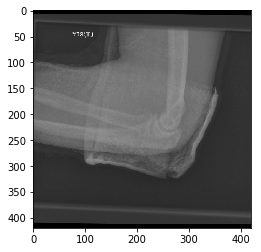

In [18]:
# Display the image
plt.imshow(test_image[0])
plt.plot()
print("Label for the image -",test_label[0])

## Trying out a Inception base model with pretrained ImageNet weights
To do:
1. Import the pretrained Inception model from Keras. - DONE
2. Change/add the last dense layer in Inception to finally have one 1 neuron(normal/abnormal) instead of 1000 neurons required in the ImageNet challenge. - DONE
3. Freeze the Inception layers to prevent large gradient update from ruining the important features. - DONE
4. Train the model - <b>Fix constant train acc/loss and very volatile valid acc/loss - DONE</b>
5. Get a baseline accuracy.  Validation accuracy on vanilla Inception = 76%
6. Finetune model
7. Get the finetuned accuracy.

In [0]:
#del Inception_model

In [20]:
# Import the pretrained Inception model from Keras
from keras.applications.inception_v3 import InceptionV3

conv_base = InceptionV3(weights='imagenet',include_top=False,input_shape=(SIZE,SIZE,3))

Using TensorFlow backend.


In [21]:
# Our base Inception model with imagenet weights
conv_base.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 420, 420, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 209, 209, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 209, 209, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 209, 209, 32) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [22]:
# Add 2 dense layers to the Inception model so that we get a sigmoid output
from keras import models
from keras import layers
from keras import optimizers

Inception_model = models.Sequential()

# Freeze the original Inception layer weights
conv_base.trainable = False

Inception_model.add(layers.BatchNormalization(axis=-1,center=True,scale=True,input_shape=(SIZE,SIZE,3)))
Inception_model.add(conv_base)
Inception_model.add(layers.pooling.GlobalAveragePooling2D())
#Inception_model.add(layers.Flatten())
Inception_model.add(layers.Dense(256,activation='relu'))
Inception_model.add(layers.Dense(1,activation='sigmoid'))

Inception_model.compile(loss='binary_crossentropy',optimizer=optimizers.Adam(lr=0.0001),metrics=['acc'])

# The model summary after freezing original Inception weights and adding our 2 dense layers
Inception_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_95 (Batc (None, 420, 420, 3)       12        
_________________________________________________________________
inception_v3 (Model)         (None, 11, 11, 2048)      21802784  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               524544    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 22,327,597
Trainable params: 524,807
Non-trainable params: 21,802,790
_________________________________________________________________


In [0]:
# Try to create a simple generator using our dataset
from keras import backend as K

def trainGenData():
  # Create an iterator to test our pipeline
  iterator = train_dataset.make_one_shot_iterator()
  # Next batch
  next_batch = iterator.get_next()
  while True:
    yield K.get_session().run(next_batch)
    
def validGenData():
  # Create an iterator to test our pipeline
  iterator = valid_dataset.make_one_shot_iterator()
  # Next batch
  next_batch = iterator.get_next()
  while True:
    yield K.get_session().run(next_batch)

trainGen = trainGenData()
validGen = validGenData()

Label 0 count = 2925
Label 1 count = 2006
Class 0 weight = 0.6858119658119658
Class 1 weight = 1.4581256231306081


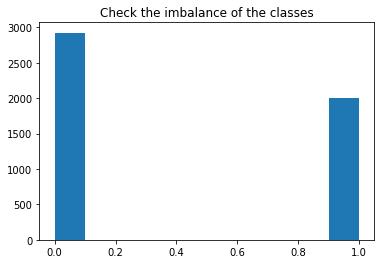

In [24]:
# Check the balance of our class labels
plt.hist(train_label_list)
plt.title('Check the imbalance of the classes')
plt.plot()

# Get the counts to set the class weights
count_0 = 0
count_1 = 0
for label in train_label_list:
  if label==0:
    count_0+=1
  else:
    count_1+=1

print('Label 0 count =',count_0)
print('Label 1 count =',count_1)

weight_0 = count_1 / count_0
weight_1 = count_0 /count_1

print('Class 0 weight =',weight_0)
print('Class 1 weight =',weight_1)

## Fitting the model works! Now we need to evaluate the model

In [25]:
# Fit the model using proper generators
# Setup callbacks to save the best model and early stopping if val loss doesn't decrease after 2 epochs
# https://chrisalbon.com/deep_learning/keras/neural_network_early_stopping/
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Set callback functions to early stop training and save the best model so far
callbacks = [EarlyStopping(monitor='val_loss', patience=2),ModelCheckpoint(filepath='best_model_freezed.h5', monitor='val_acc', save_best_only=True)]

# Set the max number of epochs
EPOCHS = 10
history = Inception_model.fit_generator(generator=trainGen,steps_per_epoch=len(train_image_list)/BATCH_SIZE,epochs=EPOCHS,validation_data=validGen,validation_steps=len(valid_image_list)/BATCH_SIZE,class_weight=[weight_0,weight_1],callbacks=callbacks,workers=0)

Instructions for updating:
Use tf.cast instead.
Epoch 1/10
494/493 [==============================] - 311s 630ms/step - loss: 0.6517 - acc: 0.6306 - val_loss: 0.6633 - val_acc: 0.5914
Epoch 2/10
494/493 [==============================] - 297s 601ms/step - loss: 0.6073 - acc: 0.6834 - val_loss: 0.6407 - val_acc: 0.6409
Epoch 3/10
494/493 [==============================] - 297s 601ms/step - loss: 0.5923 - acc: 0.6927 - val_loss: 0.6302 - val_acc: 0.6452
Epoch 4/10
494/493 [==============================] - 295s 597ms/step - loss: 0.5800 - acc: 0.7081 - val_loss: 0.6245 - val_acc: 0.6581
Epoch 5/10
494/493 [==============================] - 296s 599ms/step - loss: 0.5761 - acc: 0.7132 - val_loss: 0.6368 - val_acc: 0.6538
Epoch 6/10
494/493 [==============================] - 297s 601ms/step - loss: 0.5667 - acc: 0.7164 - val_loss: 0.7152 - val_acc: 0.6129


Observations:
1. The training acc and loss vary just for the first epoch after which they do not change.
2. The valiadtion acc and loss are pretty good for the first 4 epochs but down drastically after that.
3. Maybe we should use a larger LR.
4. <b>We should try the shuffling train_image_list /valid_image_list and train_label_list/valid_label_list after zipping.</b>

### Problem fixed by using sklearn.utils.shuffle

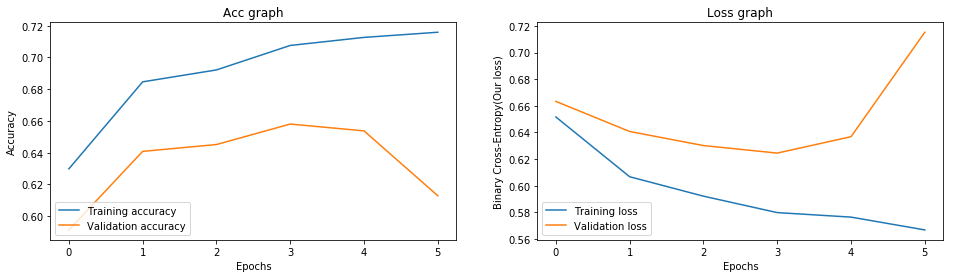

In [26]:
# Training plots
plt.rcParams["figure.figsize"] = (16,4)

train_acc = history.history['acc']
valid_acc = history.history['val_acc']
train_loss = history.history['loss']
valid_loss = history.history['val_loss']

plt.subplot(1,2,1)
plt.plot(train_acc,label='Training accuracy')
plt.plot(valid_acc,label='Validation accuracy')
plt.title('Acc graph')
plt.legend(loc='lower left')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')

plt.subplot(1,2,2)
plt.plot(train_loss,label='Training loss')
plt.plot(valid_loss,label='Validation loss')
plt.title('Loss graph')
plt.legend(loc='lower left')
plt.ylabel('Binary Cross-Entropy(Our loss)')
plt.xlabel('Epochs')

plt.show()

In [27]:
from keras.models import load_model
Inception_model = load_model('best_model_freezed.h5')

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:327: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


In [28]:
# Try to evaluate our model at this stage before unfreezing some VGG layers and then re-fitting our model
evaluation = Inception_model.evaluate_generator(generator=validGen,steps=len(valid_image_list)/BATCH_SIZE,workers=0)
print('Evaluation loss =',evaluation[0])
print('Evaluation accuracy =',evaluation[1]*100)

Evaluation loss = 0.6245068141850092
Evaluation accuracy = 65.80645182440358


In [0]:
# Save the model
Inception_model.save('Inception_base.h5')

### To do: Fine tune the model further by unfreezing some layers and re-fitting the model.

<i>Manual Testing</i>

In [0]:
manual_test = next(validGen)

In [67]:
manual_test_img = manual_test[0]
manual_test_label = manual_test[1]

Inception_model.predict(manual_test_img)

array([[0.28615984],
       [0.11534655],
       [0.13842535],
       [0.19587255],
       [0.3291961 ],
       [0.06690338],
       [0.1384601 ],
       [0.09768224],
       [0.7298154 ],
       [0.10977982]], dtype=float32)

In [68]:
manual_test_label

array([1, 0, 0, 1, 0, 0, 0, 1, 1, 1], dtype=int32)

<i>Checks Out!</i>

### Save the model

In [0]:
# Save the model
Inception_model.save('Inception_elbow.h5')

In [70]:
# Dwonload this saved model
from google.colab import files
files.download('Inception_elbow.h5')

----------------------------------------
Exception happened during processing of request from ('::ffff:127.0.0.1', 44398, 0, 0)
Traceback (most recent call last):
  File "/usr/lib/python3.6/socketserver.py", line 317, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 348, in process_request
    self.finish_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 361, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/usr/lib/python3.6/socketserver.py", line 721, in __init__
    self.handle()
  File "/usr/lib/python3.6/http/server.py", line 418, in handle
    self.handle_one_request()
  File "/usr/lib/python3.6/http/server.py", line 406, in handle_one_request
    method()
  File "/usr/lib/python3.6/http/server.py", line 639, in do_GET
    self.copyfile(f, self.wfile)
  File "/usr/lib/python3.6/http/server.py", line 800, in copyfile
    shutil.copyfil

In [71]:
len(train_label_list)

4931

In [0]:
# Get predictions from our model
predictions = Inception_model.predict_generator(validGen,steps=len(valid_image_list)/BATCH_SIZE,workers=0)

In [0]:
# Get binary predictions using a threshold
threshold = 0.5
for pred in predictions.T.tolist():
  predictions = pred
  
predictions_binary = []

for prediction in predictions:
  if prediction < threshold:
    predictions_binary.append(0)
  else:
    predictions_binary.append(1)

#predictions_binary

In [74]:
# Get the classification report
from sklearn.metrics import classification_report

report = classification_report(predictions_binary,valid_label_list)
print(report)

              precision    recall  f1-score   support

           0       0.96      0.51      0.66       444
           1       0.05      0.52      0.09        21

   micro avg       0.51      0.51      0.51       465
   macro avg       0.50      0.52      0.38       465
weighted avg       0.92      0.51      0.64       465



In [30]:
# Try to calculate Cohen's Kappa score
# In practice we need to compute this score on studies instead of individual images
from sklearn.metrics import cohen_kappa_score

cohen_kappa_score(predictions_binary,valid_label_list)

NameError: ignored

In [0]:
# Plot ROC curve
plt.rcParams["figure.figsize"] = (7,7)
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, thresholds = roc_curve(valid_label_list,predictions)
auc_score = roc_auc_score(valid_label_list,predictions)

plt.plot(fpr,tpr,label='Inception model after finetuning')
plt.plot(fpr,fpr,label='Random guessing')
plt.title('ROC score of Inception = %2.2f'%auc_score)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

plt.show()

## To do further fine-tuing by unfreezing and retraining

In [31]:
# Number of layers in our Inception conv base
print('Number of layers =',len(conv_base.layers))

Number of layers = 311


In [0]:
# Try to unfreeze the top 10 layers and train with a smaller learning rate
conv_base.trainable = True

fine_tune_at = 15

for layer in conv_base.layers[:fine_tune_at]:
  layer.trainable = False

In [33]:
# Recompile the model
Inception_model.compile(loss='binary_crossentropy',optimizer=optimizers.Adam(lr=2e-5),metrics=['acc'])
Inception_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_95 (Batc (None, 420, 420, 3)       12        
_________________________________________________________________
inception_v3 (Model)         (None, 11, 11, 2048)      21802784  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               524544    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 22,327,597
Trainable params: 22,293,159
Non-trainable params: 34,438
_________________________________________________________________


In [34]:
# Re-fit the model
# Fit the model using a very small learning rate to avoid ruining nice learnt features due to strong gradients

# Setup callbacks to save the best model and early stopping if val loss doesn't decrease after 2 epochs
# https://chrisalbon.com/deep_learning/keras/neural_network_early_stopping/
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Set callback functions to early stop training and save the best model so far
callbacks = [EarlyStopping(monitor='val_loss', patience=3),ModelCheckpoint(filepath='best_model_unfreezed.h5', monitor='val_acc', save_best_only=True)]

# Set the max number of epochs
EPOCHS = 20
history = Inception_model.fit_generator(generator=trainGen,steps_per_epoch=len(train_image_list)/BATCH_SIZE,epochs=EPOCHS,validation_data=validGen,validation_steps=len(valid_image_list)/BATCH_SIZE,class_weight=[weight_0,weight_1],callbacks=callbacks,workers=0)

Epoch 1/20
494/493 [==============================] - 342s 693ms/step - loss: 0.5058 - acc: 0.7597 - val_loss: 0.4193 - val_acc: 0.8172
Epoch 2/20
494/493 [==============================] - 333s 675ms/step - loss: 0.4160 - acc: 0.8235 - val_loss: 0.3609 - val_acc: 0.8473
Epoch 3/20
494/493 [==============================] - 334s 677ms/step - loss: 0.3523 - acc: 0.8522 - val_loss: 0.3644 - val_acc: 0.8495
Epoch 4/20
494/493 [==============================] - 333s 673ms/step - loss: 0.3031 - acc: 0.8721 - val_loss: 0.3831 - val_acc: 0.8387
Epoch 5/20
494/493 [==============================] - 331s 671ms/step - loss: 0.2502 - acc: 0.9000 - val_loss: 0.3866 - val_acc: 0.8323


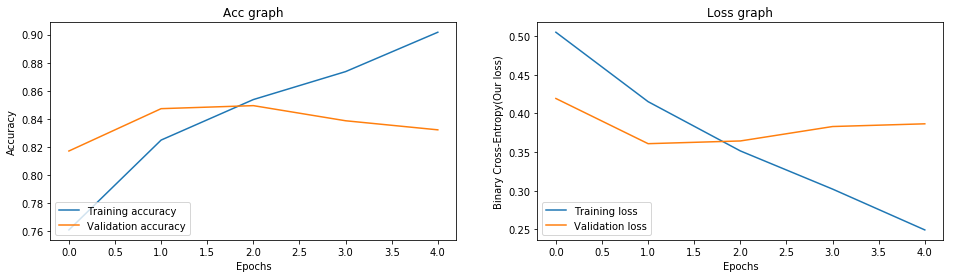

In [35]:
# Training plots
plt.rcParams["figure.figsize"] = (16,4)

train_acc = history.history['acc']
valid_acc = history.history['val_acc']
train_loss = history.history['loss']
valid_loss = history.history['val_loss']

plt.subplot(1,2,1)
plt.plot(train_acc,label='Training accuracy')
plt.plot(valid_acc,label='Validation accuracy')
plt.title('Acc graph')
plt.legend(loc='lower left')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')

plt.subplot(1,2,2)
plt.plot(train_loss,label='Training loss')
plt.plot(valid_loss,label='Validation loss')
plt.title('Loss graph')
plt.legend(loc='lower left')
plt.ylabel('Binary Cross-Entropy(Our loss)')
plt.xlabel('Epochs')

plt.show()

In [36]:
# Try to evaluate our model at this stage before unfreezing some VGG layers and then re-fitting our model
evaluation = Inception_model.evaluate_generator(generator=validGen,steps=len(valid_image_list)/BATCH_SIZE,workers=0)
print('Evaluation loss =',evaluation[0])
print('Evaluation accuracy =',evaluation[1]*100)

Evaluation loss = 0.3865673173499364
Evaluation accuracy = 83.22580584915735


<i>Save model to google drive</i>

In [49]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# 2. Save Keras Model or weights on google drive

# create on Colab directory
Inception_model.save('Inception_finetuned.h5')    
model_file = drive.CreateFile({'title' : 'Inception_finetuned.h5'})
model_file.SetContentFile('Inception_finetuned.h5')
model_file.Upload()

# download to google drive
drive.CreateFile({'id': model_file.get('id')})

    100% |████████████████████████████████| 993kB 18.8MB/s 


KeyboardInterrupt: ignored

<i>Load model from Google drive</i>

In [0]:
# https://drive.google.com/open?id=1vOjHFSDj7UF5A5SjGnwFLIUGc-jDoghP
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# 2. Download the model file
file_id = '1vOjHFSDj7UF5A5SjGnwFLIUGc-jDoghP' # URL id. 
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('Inception_finetuned.h5')

In [0]:
# Load the downloaded model from our .h5 file
from keras.models import load_model
Inception_model = load_model('Inception_finetuned.h5')

In [0]:
Inception_model.summary()

## The model didn't get enough epochs to refitting it

In [0]:
# Re-fit the model
# Fit the model using a very small learning rate to avoid ruining nice learnt features due to strong gradients

# Setup callbacks to save the best model and early stopping if val loss doesn't decrease after 2 epochs
# https://chrisalbon.com/deep_learning/keras/neural_network_early_stopping/
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Set callback functions to early stop training and save the best model so far
callbacks = [EarlyStopping(monitor='val_loss', patience=2),ModelCheckpoint(filepath='best_model_unfreezed.h5', monitor='val_acc', save_best_only=True)]

# Set the max number of epochs
EPOCHS = 10
history = Inception_model.fit_generator(generator=trainGen,steps_per_epoch=len(train_image_list)/BATCH_SIZE,epochs=EPOCHS,validation_data=validGen,validation_steps=len(valid_image_list)/BATCH_SIZE,class_weight=[weight_0,weight_1],workers=0)

#### Locally save the model

In [0]:
# Save the model (locally)
Inception_model.save('Inception_elbow_finetuned_10epochs.h5')

In [38]:
# Dwonload this saved model
from google.colab import files
files.download('Inception_elbow_finetuned_10epochs.h5')

----------------------------------------
Exception happened during processing of request from ('::ffff:127.0.0.1', 39956, 0, 0)
Traceback (most recent call last):
  File "/usr/lib/python3.6/socketserver.py", line 317, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 348, in process_request
    self.finish_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 361, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/usr/lib/python3.6/socketserver.py", line 721, in __init__
    self.handle()
  File "/usr/lib/python3.6/http/server.py", line 418, in handle
    self.handle_one_request()
  File "/usr/lib/python3.6/http/server.py", line 406, in handle_one_request
    method()
  File "/usr/lib/python3.6/http/server.py", line 639, in do_GET
    self.copyfile(f, self.wfile)
  File "/usr/lib/python3.6/http/server.py", line 800, in copyfile
    shutil.copyfil

#### Get predictions for further metrics

In [0]:
# Get predictions from our model
predictions = Inception_model.predict_generator(validGen,steps=len(valid_image_list)/BATCH_SIZE,workers=0)

In [0]:
# Get binary predictions using a threshold
threshold = 0.5
for pred in predictions.T.tolist():
  predictions = pred
  
predictions_binary = []

for prediction in predictions:
  if prediction < threshold:
    predictions_binary.append(0)
  else:
    predictions_binary.append(1)

#predictions_binary

In [41]:
# Get the classification report
from sklearn.metrics import classification_report

report = classification_report(predictions_binary,valid_label_list)
print(report)

              precision    recall  f1-score   support

           0       0.85      0.83      0.84       241
           1       0.82      0.84      0.83       224

   micro avg       0.83      0.83      0.83       465
   macro avg       0.83      0.83      0.83       465
weighted avg       0.83      0.83      0.83       465



## Try to squeeze accuracy by adding more epochs

In [0]:
# Re-fit the model
# Fit the model using a very small learning rate to avoid ruining nice learnt features due to strong gradients
# Setup callbacks to save the best model and early stopping if val loss doesn't decrease after 2 epochs
# https://chrisalbon.com/deep_learning/keras/neural_network_early_stopping/
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Set callback functions to early stop training and save the best model so far
callbacks = [EarlyStopping(monitor='val_loss', patience=2),ModelCheckpoint(filepath='best_model.h5', monitor='val_acc', save_best_only=True)]

EPOCHS = 10
history_new = Inception_model.fit_generator(generator=trainGen,steps_per_epoch=len(train_image_list)/BATCH_SIZE,epochs=EPOCHS,validation_data=validGen,validation_steps=len(valid_image_list)/BATCH_SIZE,class_weight=[weight_0,weight_1],callbacks=callbacks,workers=0)

Epoch 1/10
494/493 [==============================] - 399s 807ms/step - loss: 0.1880 - acc: 0.9261 - val_loss: 0.4376 - val_acc: 0.8688
Epoch 2/10
494/493 [==============================] - 399s 808ms/step - loss: 0.1751 - acc: 0.9294 - val_loss: 0.4128 - val_acc: 0.8645
Epoch 3/10
494/493 [==============================] - 399s 807ms/step - loss: 0.1570 - acc: 0.9374 - val_loss: 0.4764 - val_acc: 0.8366
Epoch 4/10
494/493 [==============================] - 399s 808ms/step - loss: 0.1373 - acc: 0.9488 - val_loss: 0.5119 - val_acc: 0.8452


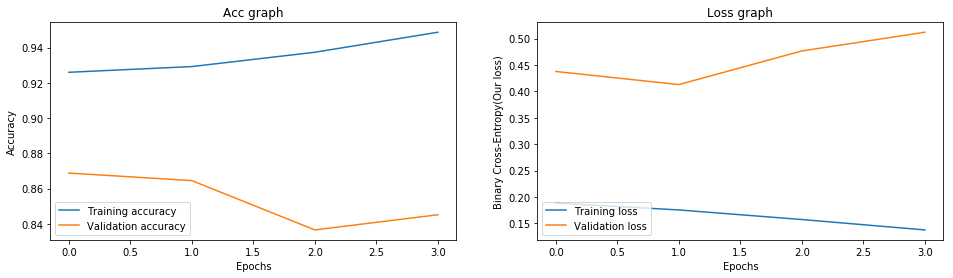

In [0]:
# Training plots
plt.rcParams["figure.figsize"] = (16,4)

train_acc = history_new.history['acc']
valid_acc = history_new.history['val_acc']
train_loss = history_new.history['loss']
valid_loss = history_new.history['val_loss']

plt.subplot(1,2,1)
plt.plot(train_acc,label='Training accuracy')
plt.plot(valid_acc,label='Validation accuracy')
plt.title('Acc graph')
plt.legend(loc='lower left')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')

plt.subplot(1,2,2)
plt.plot(train_loss,label='Training loss')
plt.plot(valid_loss,label='Validation loss')
plt.title('Loss graph')
plt.legend(loc='lower left')
plt.ylabel('Binary Cross-Entropy(Our loss)')
plt.xlabel('Epochs')

plt.show()

### The model at this stage is showing signs of overfitting!

In [0]:
# Load our best model as Inception
from keras.models import load_model

Inception_best = load_model('best_model.h5')

In [0]:
# Try to evaluate our model at this stage before unfreezing some VGG layers and then re-fitting our model
evaluation = Inception_best.evaluate_generator(generator=validGen,steps=len(valid_image_list)/BATCH_SIZE,workers=0)
print('Evaluation loss =',evaluation[0])
print('Evaluation accuracy =',evaluation[1]*100)

Evaluation loss = 0.43760223278114874
Evaluation accuracy = 86.8817195456515


In [0]:
# Save the model
Inception_best.save('Inception_elbow_finetuned_20epochs.h5')

In [0]:
# Dwonload this saved model
from google.colab import files
files.download('Inception_elbow_finetuned_20epochs.h5')

In [0]:
# Get predictions from our model
predictions = Inception_best.predict_generator(validGen,steps=len(valid_image_list)/BATCH_SIZE,workers=0)

In [0]:
# Get binary predictions using a threshold
threshold = 0.5
for pred in predictions.T.tolist():
  predictions = pred
  
predictions_binary = []

for prediction in predictions:
  if prediction < threshold:
    predictions_binary.append(0)
  else:
    predictions_binary.append(1)

#predictions_binary

## Add some dropout and try to further fit the model

In [0]:
# Re-fit the model after adding dropout
# Setup callbacks to save the best model and early stopping if val loss doesn't decrease after 2 epochs
# https://chrisalbon.com/deep_learning/keras/neural_network_early_stopping/
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Set callback functions to early stop training and save the best model so far
callbacks = [EarlyStopping(monitor='val_loss', patience=2),ModelCheckpoint(filepath='best_model_dropout.h5', monitor='val_loss', save_best_only=True)]

EPOCHS = 50
history_new = Inception_best_dropout.fit_generator(generator=trainGen,steps_per_epoch=len(train_image_list)/BATCH_SIZE,epochs=EPOCHS,validation_data=validGen,validation_steps=len(valid_image_list)/BATCH_SIZE,class_weight=[weight_0,weight_1],callbacks=callbacks,workers=0)

Epoch 1/50
494/493 [==============================] - 348s 705ms/step - loss: 0.3512 - acc: 0.8605 - val_loss: 0.4370 - val_acc: 0.8473
Epoch 2/50
383/493 [======================>.......] - ETA: 1:13 - loss: 0.3431 - acc: 0.8650

In [42]:
# Add dropout between the flatten - fc1 and fc1 - fc2 layers
# https://stackoverflow.com/questions/42475381/add-dropout-layers-between-pretrained-dense-layers-in-keras
from keras.layers import Dropout
from keras.models import Model

#Inception_best.layers[:-2]

# Define the dropout layers
dropout1 = Dropout(0.7)
dropout2 = Dropout(0.75)

# Store the previous layers
till_pooling = Inception_model.layers[-3]
second_last_dense_layer = Inception_model.layers[-2]
last_dense_layer = Inception_model.layers[-1]

# Reconnect the layers
x = dropout1(till_pooling.output)
x = second_last_dense_layer(x)
x = dropout2(x)
predictors = last_dense_layer(x)

# Create a new model
Inception_best_dropout = Model(input=Inception_model.input, output=predictors)

# Compile the model
Inception_best_dropout.compile(loss='binary_crossentropy',optimizer=optimizers.Adam(lr=1e-6),metrics=['acc'])

Inception_best_dropout.summary()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_95_input (None, 420, 420, 3)       0         
_________________________________________________________________
batch_normalization_95 (Batc (None, 420, 420, 3)       12        
_________________________________________________________________
inception_v3 (Model)         (None, 11, 11, 2048)      21802784  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               524544    
___________________________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("ba..., outputs=Tensor("de...)`


In [43]:
# Re-fit the model after adding dropout
# Setup callbacks to save the best model and early stopping if val loss doesn't decrease after 2 epochs
# https://chrisalbon.com/deep_learning/keras/neural_network_early_stopping/
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Set callback functions to early stop training and save the best model so far
callbacks = [EarlyStopping(monitor='val_loss', patience=2),ModelCheckpoint(filepath='best_model_dropout.h5', monitor='val_loss', save_best_only=True)]

EPOCHS = 50
history_new = Inception_best_dropout.fit_generator(generator=trainGen,steps_per_epoch=len(train_image_list)/BATCH_SIZE,epochs=EPOCHS,validation_data=validGen,validation_steps=len(valid_image_list)/BATCH_SIZE,class_weight=[weight_0,weight_1],callbacks=callbacks,workers=0)

Epoch 1/50
494/493 [==============================] - 346s 701ms/step - loss: 0.3243 - acc: 0.8652 - val_loss: 0.3989 - val_acc: 0.8495
Epoch 2/50
494/493 [==============================] - 335s 679ms/step - loss: 0.2984 - acc: 0.8779 - val_loss: 0.4190 - val_acc: 0.8473
Epoch 3/50
494/493 [==============================] - 336s 680ms/step - loss: 0.2757 - acc: 0.8929 - val_loss: 0.4349 - val_acc: 0.8495


In [1]:
# Dwonload this saved model
from google.colab import files
files.download('best_model_dropout.h5')

FileNotFoundError: ignored

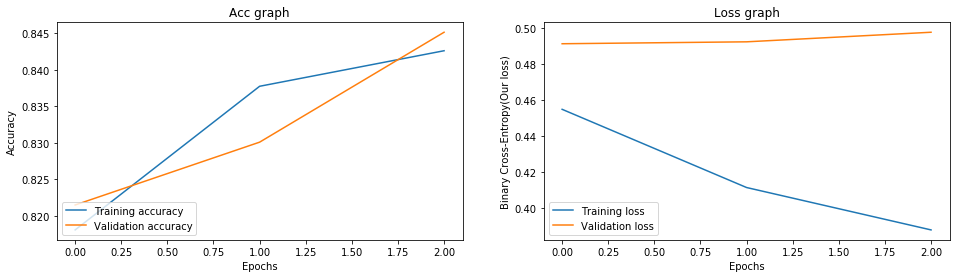

In [87]:
# Training plots
plt.rcParams["figure.figsize"] = (16,4)

train_acc = history_new.history['acc']
valid_acc = history_new.history['val_acc']
train_loss = history_new.history['loss']
valid_loss = history_new.history['val_loss']

plt.subplot(1,2,1)
plt.plot(train_acc,label='Training accuracy')
plt.plot(valid_acc,label='Validation accuracy')
plt.title('Acc graph')
plt.legend(loc='lower left')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')

plt.subplot(1,2,2)
plt.plot(train_loss,label='Training loss')
plt.plot(valid_loss,label='Validation loss')
plt.title('Loss graph')
plt.legend(loc='lower left')
plt.ylabel('Binary Cross-Entropy(Our loss)')
plt.xlabel('Epochs')

plt.show()

In [0]:
# Load our best model as Inception
from keras.models import load_model

Inception_best_dropout = load_model('best_model_dropout.h5')

In [0]:
# Try to evaluate our model at this stage before unfreezing some VGG layers and then re-fitting our model
evaluation = Inception_best_dropout.evaluate_generator(generator=validGen,steps=len(valid_image_list)/BATCH_SIZE,workers=0)
print('Evaluation loss =',evaluation[0])
print('Evaluation accuracy =',evaluation[1]*100)

Evaluation loss = 0.43760223278114874
Evaluation accuracy = 86.8817195456515


In [0]:
# Save the model
Inception_best_dropout.save('Inception_elbow_finetuned_dropout_30epochs.h5')

In [0]:
# Dwonload this saved model
from google.colab import files
files.download('Inception_elbow_finetuned_dropout_30epochs.h5')

In [0]:
# Get predictions from our model
predictions = Inception_best_dropout.predict_generator(validGen,steps=len(valid_image_list)/BATCH_SIZE,workers=0)

In [0]:
# Get binary predictions using a threshold
threshold = 0.5
for pred in predictions.T.tolist():
  predictions = pred
  
predictions_binary = []

for prediction in predictions:
  if prediction < threshold:
    predictions_binary.append(0)
  else:
    predictions_binary.append(1)

#predictions_binary

In [0]:
# Get the classification report
from sklearn.metrics import classification_report

report = classification_report(predictions_binary,valid_label_list)
print(report)

              precision    recall  f1-score   support

           0       0.92      0.83      0.88       260
           1       0.81      0.91      0.86       205

   micro avg       0.87      0.87      0.87       465
   macro avg       0.87      0.87      0.87       465
weighted avg       0.87      0.87      0.87       465



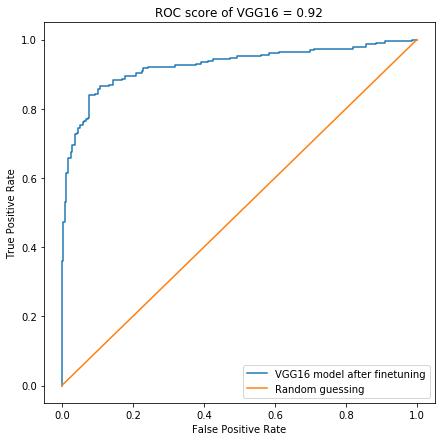

In [0]:
# Plot ROC curve
plt.rcParams["figure.figsize"] = (7,7)
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, thresholds = roc_curve(valid_label_list,predictions)
auc_score = roc_auc_score(valid_label_list,predictions)

plt.plot(fpr,tpr,label='Inception model after finetuning and dropout')
plt.plot(fpr,fpr,label='Random guessing')
plt.title('ROC score of Inception(finetuning+dropout) = %2.2f'%auc_score)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

plt.show()